# Prediction of steel temperature on steel manufacturing

# Content

1. [Project Description](#section_1)
2. [Exploratory data analysis](#section_2)
3. [Data Preparation](#section_3)
4. [Models training](#section_4)
5. [Model Testing  and demonstration of work](#section_5)
6. [General Conclusion](#section_6)

<a name ='section_1'></a>
# Project Description

Steel manufacturing company requested to develop the system for the prediction of steel temperature for the optimization of electricity costs. Based on the provided data from company it's required to conduct an analysis and train a models for the prediction of the steel temperature.

**Project goal:** *train a model for the prediction of the steel temperature for optimization of electricity cost during production.*


**Project tasks are following:**
- To connect to database and load the initial data;
- Overview the data and conduct the exploratory data analysis;
- To prepare the data, select the target and features;
- Train the models;
- Select the best model and test it.

<a name ='section_2'></a>
# 1. Exploratory data analysis

import of libraries

In [1]:
pip install phik

     ------------------------------------ 663.4/663.4 kB 746.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import datetime
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from phik import resources, report
import phik
import seaborn as sns

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

connection to data base

In [4]:
db_config = {
'user': '*********', # имя пользователя,
'pwd': '******', # пароль,
'host': '*************',
'port': ****, # порт подключения,
'db': '*********' # название базы данных,
} 

In [5]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [6]:
engine = create_engine(connection_string) 

## 1.1 Data loading

In [7]:
query = '''
SELECT *
FROM steel.data_arc 
'''

arc_df = pd.read_sql_query(query, con=engine) 

In [8]:
query = '''
SELECT *
FROM steel.data_bulk
'''

bulk_df = pd.read_sql_query(query, con=engine) 

In [9]:
query = '''
SELECT *
FROM steel.data_bulk_time 
'''

bulk_time_df = pd.read_sql_query(query, con=engine) 

In [10]:
query = '''
SELECT *
FROM steel.data_gas
'''

gas_df = pd.read_sql_query(query, con=engine) 

In [11]:
query = '''
SELECT *
FROM steel.data_temp
'''

tempperature_df = pd.read_sql_query(query, con=engine) 

In [12]:
query = '''
SELECT *
FROM steel.data_wire 
'''

wire_df = pd.read_sql_query(query, con=engine) 

In [13]:
query = '''
SELECT *
FROM steel.data_wire_time 
'''

wire_time_df = pd.read_sql_query(query, con=engine) 

## 1.2 Data overview

### 1.2.1 data_arc dataset overview

In [14]:
query = '''

    SELECT *, 
    ROW_NUMBER() OVER () as row
    FROM steel.data_arc 
    ORDER BY row
'''

temp_df = pd.read_sql_query(query, con=engine) 

In [15]:
temp_df

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,row
0,1,11:02:14,11:06:02,0.976059,0.687084,1
1,1,11:07:28,11:10:33,0.805607,0.520285,2
2,1,11:11:44,11:14:36,0.744363,0.498805,3
3,1,11:18:14,11:24:19,1.659363,1.062669,4
4,1,11:26:09,11:28:37,0.692755,0.414397,5
...,...,...,...,...,...,...
14871,3241,03:58:58,04:01:35,0.533670,0.354439,14872
14872,3241,04:05:04,04:08:04,0.676604,0.523631,14873
14873,3241,04:16:41,04:19:45,0.733899,0.475654,14874
14874,3241,04:31:51,04:32:48,0.220694,0.145768,14875


In [16]:
len(temp_df['key'].unique())

3214

**Data_arc dataset has:**
- information on batch number 
- start and finish heating time of batch in format hh:mm:ss;
- used active and reactive powers;
- the total of 148876 rows;
- information on 3214 batches of steel. 

### 1.2.2 Additionally to the data analysis client requested tp calculate the following information:

•	for every value of key column:

1)	Calculate the time between first and last temperature measurement

2)  Total cumulative heating time.

3)	Total quantity of heating.

4)	Average ratio of active and reactive power;

5)	For all obtained information to calculate: average, minimal, maximum, median and 25% and 75 % quartiles.

**Query for loading of data required to execute tasks specified above:**

In [17]:
query = '''

WITH table_1 AS (
    SELECT ROW_NUMBER() OVER () as row,*    
    FROM steel.data_arc 
    ORDER BY row
    ),

heat_time AS (
           SELECT key, row,
                  FIRST_VALUE("BeginHeat") OVER ( PARTITION BY key ORDER BY row) AS heat_start,
                  FIRST_VALUE("EndHeat") OVER (PARTITION BY key ORDER BY row DESC) AS heat_finish, 
                  "ActivePower",
                  "ReactivePower", 
                  CASE
                      WHEN 
                        ((DATE_TRUNC('second' , "EndHeat") - DATE_TRUNC('second' ,"BeginHeat")) > '00:00:00')
                        THEN
                           DATE_TRUNC('second' , "EndHeat") - DATE_TRUNC('second' ,"BeginHeat")
                      ELSE 
                           DATE_TRUNC('second' , "EndHeat") + '24:00:00' - DATE_TRUNC('second' ,"BeginHeat")
                END as heat_time       
             FROM table_1),
             
time_temp AS (SELECT *, 
                     ROW_NUMBER() OVER () as row
                FROM steel.data_temp 
               ORDER BY row),


temp_st_fn AS   (SELECT key,
                       FIRST_VALUE("MesaureTime") OVER (PARTITION BY key ORDER BY row DESC) AS measure_temp_finish,
                       FIRST_VALUE("MesaureTime") OVER ( PARTITION BY key ORDER BY row) AS measure_temp_start
                  FROM time_temp),             

total_time_mes AS (SELECT DISTINCT key,
                          CASE
                              WHEN 
                                  DATE_TRUNC('second' ,measure_temp_start) > DATE_TRUNC('second' , measure_temp_finish)
                                  THEN
                                      DATE_TRUNC('second' , measure_temp_finish) +'24:00:00' - DATE_TRUNC('second' ,measure_temp_start)
                              ELSE 
                                      DATE_TRUNC('second' , measure_temp_finish) - DATE_TRUNC('second' ,measure_temp_start)
                              END AS ttl_msr_time
                     FROM temp_st_fn
                     ),
             
key_count AS (SELECT key,
                     COUNT(key) as heat_qty
               FROM table_1 as t                    
               GROUP BY key),
              
    
cumul_table  AS  (SELECT DISTINCT ht.key,
                         kc.heat_qty,
                         (DATE_TRUNC('second', SUM (heat_time))) AS ttl_heat_time,
                         heat_start,
                         heat_finish,
                         CASE
                             WHEN 
                                 DATE_TRUNC('second' ,heat_start) > DATE_TRUNC('second' , heat_finish)
                                 THEN
                                     DATE_TRUNC('second' , heat_finish) +'24:00:00' - DATE_TRUNC('second' ,heat_start)
                             ELSE 
                                     DATE_TRUNC('second' , heat_finish) - DATE_TRUNC('second' ,heat_start)
                             END AS total_time,
                         SUM("ActivePower")/SUM("ReactivePower") AS avg_cumul_power
                    FROM heat_time as ht
                         INNER JOIN key_count as kc
                            ON ht.key = kc.key
                   GROUP BY ht.key,heat_qty, heat_start,heat_finish,total_time)

SELECT 
       t.key,
       ms.ttl_msr_time,
       c.heat_qty,
       c.ttl_heat_time,
       c.avg_cumul_power 
  FROM table_1 AS t
       LEFT JOIN 
            cumul_table AS c
         ON c.key = t.key
       LEFT JOIN 
            total_time_mes AS ms
         ON ms.key = t.key
 ORDER BY t.row
'''

arc_df = pd.read_sql_query(query, con=engine) 

In [18]:
# display of loaded dataset
arc_df.head(10)

,key,ttl_msr_time,heat_qty,ttl_heat_time,avg_cumul_power
0,1,0 days 00:14:21,5,0 days 00:18:18,1.532447
1,1,0 days 00:14:21,5,0 days 00:18:18,1.532447
2,1,0 days 00:14:21,5,0 days 00:18:18,1.532447
3,1,0 days 00:14:21,5,0 days 00:18:18,1.532447
4,1,0 days 00:14:21,5,0 days 00:18:18,1.532447
5,2,0 days 00:21:45,4,0 days 00:13:31,1.527741
6,2,0 days 00:21:45,4,0 days 00:13:31,1.527741
7,2,0 days 00:21:45,4,0 days 00:13:31,1.527741
8,2,0 days 00:21:45,4,0 days 00:13:31,1.527741
9,3,0 days 00:21:40,5,0 days 00:10:55,1.579589


In [19]:
arc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   key              14876 non-null  int64          
 1   ttl_msr_time     14876 non-null  timedelta64[ns]
 2   heat_qty         14876 non-null  int64          
 3   ttl_heat_time    14876 non-null  timedelta64[ns]
 4   avg_cumul_power  14876 non-null  float64        
dtypes: float64(1), int64(2), timedelta64[ns](2)
memory usage: 581.2 KB


In [20]:
# display of statistic for arc_df
arc_df[['heat_qty','ttl_heat_time','ttl_msr_time','avg_cumul_power']].describe(include= 'all')

,heat_qty,ttl_heat_time,ttl_msr_time,avg_cumul_power
count,14876.000000,14876,14876,14876.000000
mean,5.187416,0 days 00:14:44.377251949,0 days 00:35:01.399569776,1.347103
std,1.749516,0 days 00:06:01.987921323,0 days 00:27:52.649173821,0.140887
min,1.000000,0 days 00:00:57,0 days 00:03:17,-0.002587
25%,4.000000,0 days 00:10:52,0 days 00:21:32,1.279535
50%,5.000000,0 days 00:14:06,0 days 00:29:06,1.362585
75%,6.000000,0 days 00:17:42,0 days 00:40:57,1.435037
max,16.000000,0 days 01:09:49,0 days 06:32:17,1.777119


**The conclusions are following:**
1) quantity of heating:
- Minimal - 1;
- Maximal - 16;
- Median - 5;

2) Interval from from first to last temperature measurement:
- Minimal time - 3 min. 17 sec.;
- Maximal - 6 h. 32 min. 17 sec.;
- Median value - 29 min. 6 sec;

3) total heating time:
- Minimal - 57 sec;
- Maximal - 1 ч 9 min  49 sec;
- Median - 14 min 6 sec;

4) Average ratio of active power to reactive power:
- Minimal  -0,02;
- Maximal 1,77;
- Median  1,36.

 ## 1.3 data bulk (quantity) overview

In [21]:
bulk_df.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [22]:
bulk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


**The dataset has the following information:**
- information on batch number - 3129 unique values;
- Columns with specified quantity of bulk for every batch;
- dataset has nulls - it's acceptable and not required to fill in - every batch is different to other and requires different bulk materials as well as quantity.

## 1.4 data bulk (time) overview

In [23]:
bulk_time_df.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


In [24]:
bulk_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


**Bulk (time) dataset has:**
- info on batch number - 3129 unique values;
- columns with specified time of bulk insertion for every batch;
- dataset has nulls - it's acceptable and not required to fill in - every batch is different to other and requires different bulk materials as well as quantity.

## 1.5 gas dataset overview

In [25]:
gas_df.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [26]:
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


**Gas dataset has:**
- information on batch number and quantity of used gas - total 3239 rows. 

## 1.6 Temperature dataset overview

In [27]:
tempperature_df.head()

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


In [28]:
tempperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [29]:
len(tempperature_df['key'].unique())

3216

In [30]:
tempperature_df[tempperature_df['key']==1]

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


**temperature dataset has:**
- information on batch number - 3216 unique values;
- temperature measurement for every batch - with time measurement; and temperature the total quantity of records is 15907.

## 1.7 Wire dataset (quantity) oveview

In [31]:
wire_df.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
wire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


**Wire (quantity) dataset has:**
- information on quantity of insertion of 9 different types o wire materials;
- information on batch number - 3081 of unique values;
- dataset has nulls - it's acceptable and not required to fill in - every batch is different to other and requires different wire materials as well as quantity.

## 1.8 Wire dataset (time) oveview

In [33]:
wire_time_df.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


In [34]:
wire_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


**Wire (time) dataset has:**
- information on time of insertion of wired materials;
- information on number of batch - 3081 unique values;
- dataset has nulls - it's acceptable and not required to fill in - every batch is different to other and requires different wire materials as well as quantity.

<a name ='section_3'></a>
# 2 Data preparation

**Goal of this section to prepare one dataset with target and features for the further models training.**

**Project target is temperature.** 

Due to the fact that every bath has several quantity of temperature measurement, all features to be prepared in accordance with relevant duration for each production batch and number of temperature measurement.

The time of start of production to be used as 0 time.

**For the obtaining of correct features the following actions required to complete:**
1) Create dataset with unique batch number and temperature measurement related to number of measurement;

2) To merge the dataset of quantity and time of bulk materials and add to dataset with target;

3) To merge the dataset of quantity and time of wire materials and add to dataset with target;

4) To merge heating dataset with obtained dataset considering the batch number and time of insertion of materials;;

4) To add gas dataset to the dataset with target;

5) To unify the format of dataset values, process the nulls.

## 2.1 Create dataset with unique batch numer and temperature considering the number of temperture measurement.

In [35]:
query = '''
WITH time_temp AS (SELECT *, 
                          ROW_NUMBER() OVER (PARTITION BY key) as msr_num
                     FROM steel.data_temp 
                    ORDER BY key)
               
SELECT DISTINCT key,
       FIRST_VALUE("Temperature") OVER ( PARTITION BY key ORDER BY msr_num) AS first_temperature,
       FIRST_VALUE("Temperature") OVER ( PARTITION BY key ORDER BY msr_num DESC) AS final_temperature,
       
       
       FIRST_VALUE("MesaureTime") OVER ( PARTITION BY key ORDER BY msr_num) AS first_temp_time,
       FIRST_VALUE("MesaureTime") OVER ( PARTITION BY key ORDER BY msr_num DESC) AS final_temp_time
  FROM time_temp
 ORDER BY key
               
'''

temperature_df = pd.read_sql_query(query, con=engine) 

In [36]:
temperature_df.head(10)

,key,first_temperature,final_temperature,first_temp_time,final_temp_time
0,1,1571.0,1613.0,11:16:18,11:30:39
1,2,1581.0,1602.0,11:37:27,11:59:12
2,3,1596.0,1599.0,12:13:17,12:34:57
3,4,1601.0,1625.0,12:52:57,12:59:25
4,5,1576.0,1602.0,13:23:19,13:36:01
5,6,1543.0,1596.0,13:49:24,14:12:29
6,7,1586.0,1599.0,14:19:43,14:42:37
7,8,1577.0,1598.0,15:07:18,15:22:52
8,9,1587.0,1592.0,15:37:03,16:01:16
9,10,1574.0,1593.0,16:14:29,16:36:08


In [37]:
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                3216 non-null   int64  
 1   first_temperature  3216 non-null   float64
 2   final_temperature  2477 non-null   float64
 3   first_temp_time    3216 non-null   object 
 4   final_temp_time    3216 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 125.8+ KB


**Deletion of nulls**

In [38]:
temperature_df['na_check'] = temperature_df['final_temperature'].isna()

In [39]:
keys_to_drop = temperature_df[temperature_df['na_check'] == 1]['key'].drop_duplicates()

In [40]:
keys_check = []
for i in range(len(temperature_df['key'])):
    if temperature_df['key'][i] in set(keys_to_drop):
        keys_check.append('drop')
    else: 
        keys_check.append('ok')

In [41]:
temperature_df['key_check'] = keys_check

In [42]:
temperature_df = temperature_df[temperature_df['key_check'] == 'ok']

In [43]:
temperature_df = temperature_df.drop(columns = ['na_check','key_check']).reset_index(drop = True)

In [44]:
for i in temperature_df.loc[:,'first_temperature':'final_temperature'].columns:
    temperature_df[i] = temperature_df[i].fillna('0')

In [45]:
for i in temperature_df.loc[:,'first_temp_time':].columns:
    temperature_df[i] = temperature_df[i].fillna(pd.to_datetime(0, unit='s', errors='coerce').time())

In [46]:
temperature_df.head()

,key,first_temperature,final_temperature,first_temp_time,final_temp_time
0,1,1571.0,1613.0,11:16:18,11:30:39
1,2,1581.0,1602.0,11:37:27,11:59:12
2,3,1596.0,1599.0,12:13:17,12:34:57
3,4,1601.0,1625.0,12:52:57,12:59:25
4,5,1576.0,1602.0,13:23:19,13:36:01


In [47]:
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2477 non-null   int64  
 1   first_temperature  2477 non-null   float64
 2   final_temperature  2477 non-null   float64
 3   first_temp_time    2477 non-null   object 
 4   final_temp_time    2477 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 96.9+ KB


In [48]:
len(temperature_df['key'].unique())

2477

**Conclusion:**

- Prepared dataset has the size 33*2477;
- it has information on 2477 batches;
- Dataset to be used later for the creating of final table of features and target.
- The final dataset has to have the quantity of rows equal to 2477 or less. 

## 2.2 Merging the datasets with quantity and time of insertion of bulk materials and add it to dataset with target

In [49]:
bulk_jnt = bulk_df.merge(bulk_time_df,how = 'left',left_on='key', right_on='key',
          suffixes=('','_time'))

In [50]:
col_list = ['key']
for i in range(15):
    col_list.append(bulk_jnt.columns[1:16][i])
    col_list.append(bulk_jnt.columns[16:][i])

bulk_jnt = bulk_jnt[col_list]

In [51]:
bulk_jnt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 0 to 3128
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3129 non-null   int64  
 1   Bulk 1        252 non-null    float64
 2   Bulk 1_time   252 non-null    object 
 3   Bulk 2        22 non-null     float64
 4   Bulk 2_time   22 non-null     object 
 5   Bulk 3        1298 non-null   float64
 6   Bulk 3_time   1298 non-null   object 
 7   Bulk 4        1014 non-null   float64
 8   Bulk 4_time   1014 non-null   object 
 9   Bulk 5        77 non-null     float64
 10  Bulk 5_time   77 non-null     object 
 11  Bulk 6        576 non-null    float64
 12  Bulk 6_time   576 non-null    object 
 13  Bulk 7        25 non-null     float64
 14  Bulk 7_time   25 non-null     object 
 15  Bulk 8        1 non-null      float64
 16  Bulk 8_time   1 non-null      object 
 17  Bulk 9        19 non-null     float64
 18  Bulk 9_time   19 non-null   

In [52]:
bulk_jnt.head(15)

,key,Bulk 1,Bulk 1_time,Bulk 2,Bulk 2_time,Bulk 3,Bulk 3_time,Bulk 4,Bulk 4_time,Bulk 5,...,Bulk 11,Bulk 11_time,Bulk 12,Bulk 12_time,Bulk 13,Bulk 13_time,Bulk 14,Bulk 14_time,Bulk 15,Bulk 15_time
0,1,NaN,None,NaN,None,NaN,None,43.0,11:21:30,NaN,...,NaN,None,206.0,11:03:52,NaN,None,150.0,11:03:52,154.0,11:03:52
1,2,NaN,None,NaN,None,NaN,None,73.0,11:46:38,NaN,...,NaN,None,206.0,11:40:20,NaN,None,149.0,11:40:20,154.0,11:40:20
2,3,NaN,None,NaN,None,NaN,None,34.0,12:31:06,NaN,...,NaN,None,205.0,12:09:40,NaN,None,152.0,12:09:40,153.0,12:09:40
3,4,NaN,None,NaN,None,NaN,None,81.0,12:48:43,NaN,...,NaN,None,207.0,12:41:24,NaN,None,153.0,12:41:24,154.0,12:41:24
4,5,NaN,None,NaN,None,NaN,None,78.0,13:18:50,NaN,...,NaN,None,203.0,13:12:56,NaN,None,151.0,13:12:56,152.0,13:12:56
5,6,NaN,None,NaN,None,NaN,None,117.0,13:59:24,NaN,...,NaN,None,204.0,13:53:27,NaN,None,201.0,13:53:27,154.0,13:53:27
6,7,NaN,None,NaN,None,NaN,None,117.0,14:29:14,NaN,...,NaN,None,204.0,14:22:19,NaN,None,152.0,14:22:19,154.0,14:22:19
7,8,NaN,None,NaN,None,NaN,None,99.0,15:04:05,NaN,...,NaN,None,410.0,14:55:46,NaN,None,252.0,14:55:46,153.0,14:55:46
8,9,NaN,None,NaN,None,NaN,None,117.0,15:47:34,NaN,...,NaN,None,107.0,15:41:00,NaN,None,99.0,15:41:00,203.0,15:41:00
9,10,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,NaN,None,203.0,16:18:52,NaN,None,102.0,16:18:52,204.0,16:18:52


**Merging of dataset with temperature_df**

In [53]:
tmp_jnt_df = pd.merge(temperature_df,bulk_jnt,how = 'outer',on='key',indicator=True)

In [54]:
tmp_jnt_df.head()

,key,first_temperature,final_temperature,first_temp_time,final_temp_time,Bulk 1,Bulk 1_time,Bulk 2,Bulk 2_time,Bulk 3,...,Bulk 11_time,Bulk 12,Bulk 12_time,Bulk 13,Bulk 13_time,Bulk 14,Bulk 14_time,Bulk 15,Bulk 15_time,_merge
0,1,1571.0,1613.0,11:16:18,11:30:39,NaN,None,NaN,None,NaN,...,None,206.0,11:03:52,NaN,None,150.0,11:03:52,154.0,11:03:52,both
1,2,1581.0,1602.0,11:37:27,11:59:12,NaN,None,NaN,None,NaN,...,None,206.0,11:40:20,NaN,None,149.0,11:40:20,154.0,11:40:20,both
2,3,1596.0,1599.0,12:13:17,12:34:57,NaN,None,NaN,None,NaN,...,None,205.0,12:09:40,NaN,None,152.0,12:09:40,153.0,12:09:40,both
3,4,1601.0,1625.0,12:52:57,12:59:25,NaN,None,NaN,None,NaN,...,None,207.0,12:41:24,NaN,None,153.0,12:41:24,154.0,12:41:24,both
4,5,1576.0,1602.0,13:23:19,13:36:01,NaN,None,NaN,None,NaN,...,None,203.0,13:12:56,NaN,None,151.0,13:12:56,152.0,13:12:56,both


In [55]:
tmp_jnt_df = tmp_jnt_df[tmp_jnt_df['_merge'] != 'right_only']

In [56]:
# deleting of column merge
tmp_jnt_df['_merge'].unique()

['both', 'left_only']
Categories (3, object): ['left_only', 'right_only', 'both']

In [57]:
tmp_jnt_df = tmp_jnt_df.drop(columns = '_merge')

In [58]:
# fill nulls with zero value
for i in bulk_df.columns[1:]:
    tmp_jnt_df[i] = tmp_jnt_df[i].fillna(0)
    tmp_jnt_df[i] = tmp_jnt_df[i].replace(np.nan, 0)

In [59]:
for i in bulk_time_df.columns[1:]:
    tmp_jnt_df[i+'_time'] = tmp_jnt_df[i+'_time'].fillna(pd.to_datetime(0, unit='s', errors='coerce').time())

In [60]:
tmp_jnt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2477 non-null   int64  
 1   first_temperature  2477 non-null   float64
 2   final_temperature  2477 non-null   float64
 3   first_temp_time    2477 non-null   object 
 4   final_temp_time    2477 non-null   object 
 5   Bulk 1             2477 non-null   float64
 6   Bulk 1_time        2477 non-null   object 
 7   Bulk 2             2477 non-null   float64
 8   Bulk 2_time        2477 non-null   object 
 9   Bulk 3             2477 non-null   float64
 10  Bulk 3_time        2477 non-null   object 
 11  Bulk 4             2477 non-null   float64
 12  Bulk 4_time        2477 non-null   object 
 13  Bulk 5             2477 non-null   float64
 14  Bulk 5_time        2477 non-null   object 
 15  Bulk 6             2477 non-null   float64
 16  Bulk 6_time        2477 

In [61]:
tmp_jnt_df.head()

,key,first_temperature,final_temperature,first_temp_time,final_temp_time,Bulk 1,Bulk 1_time,Bulk 2,Bulk 2_time,Bulk 3,...,Bulk 11,Bulk 11_time,Bulk 12,Bulk 12_time,Bulk 13,Bulk 13_time,Bulk 14,Bulk 14_time,Bulk 15,Bulk 15_time
0,1,1571.0,1613.0,11:16:18,11:30:39,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,00:00:00,206.0,11:03:52,0.0,00:00:00,150.0,11:03:52,154.0,11:03:52
1,2,1581.0,1602.0,11:37:27,11:59:12,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,00:00:00,206.0,11:40:20,0.0,00:00:00,149.0,11:40:20,154.0,11:40:20
2,3,1596.0,1599.0,12:13:17,12:34:57,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,00:00:00,205.0,12:09:40,0.0,00:00:00,152.0,12:09:40,153.0,12:09:40
3,4,1601.0,1625.0,12:52:57,12:59:25,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,00:00:00,207.0,12:41:24,0.0,00:00:00,153.0,12:41:24,154.0,12:41:24
4,5,1576.0,1602.0,13:23:19,13:36:01,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,00:00:00,203.0,13:12:56,0.0,00:00:00,151.0,13:12:56,152.0,13:12:56


**Conclusion:**

- After merging of datasets the new dataset was obtained with size of 2447*62;

- The information on quantity and time of insertion of bulk materials were added to dataset.

## 2.3 Merging the datasets with quantity and time of insertion of wired materials and add it to dataset with target

In [62]:
wire_jnt = wire_df.merge(wire_time_df,how = 'left',left_on='key', right_on='key',
          suffixes=('','_time'))

In [63]:
col_list = ['key']
for i in range(9):
    col_list.append(wire_jnt.columns[1:10][i])
    col_list.append(wire_jnt.columns[10:][i])

wire_jnt = wire_jnt[col_list]

In [64]:
wire_jnt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 0 to 3080
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3081 non-null   int64  
 1   Wire 1       3055 non-null   float64
 2   Wire 1_time  3055 non-null   object 
 3   Wire 2       1079 non-null   float64
 4   Wire 2_time  1079 non-null   object 
 5   Wire 3       63 non-null     float64
 6   Wire 3_time  63 non-null     object 
 7   Wire 4       14 non-null     float64
 8   Wire 4_time  14 non-null     object 
 9   Wire 5       1 non-null      float64
 10  Wire 5_time  1 non-null      object 
 11  Wire 6       73 non-null     float64
 12  Wire 6_time  73 non-null     object 
 13  Wire 7       11 non-null     float64
 14  Wire 7_time  11 non-null     object 
 15  Wire 8       19 non-null     float64
 16  Wire 8_time  19 non-null     object 
 17  Wire 9       29 non-null     float64
 18  Wire 9_time  29 non-null     object 
dtypes: flo

In [65]:
wire_jnt.head()

,key,Wire 1,Wire 1_time,Wire 2,Wire 2_time,Wire 3,Wire 3_time,Wire 4,Wire 4_time,Wire 5,Wire 5_time,Wire 6,Wire 6_time,Wire 7,Wire 7_time,Wire 8,Wire 8_time,Wire 9,Wire 9_time
0,1,60.059998,11:11:41,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None
1,2,96.052315,11:46:10,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None
2,3,91.160157,12:13:47,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None
3,4,89.063515,12:48:05,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None
4,5,89.238236,13:18:15,9.11456,13:32:06,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN,None


**Merging of dataset with temperature_df**

In [66]:
tmp_jnt_df = pd.merge(tmp_jnt_df,wire_jnt,how = 'outer',on='key',indicator=True)

In [67]:
tmp_jnt_df.head()

,key,first_temperature,final_temperature,first_temp_time,final_temp_time,Bulk 1,Bulk 1_time,Bulk 2,Bulk 2_time,Bulk 3,...,Wire 5_time,Wire 6,Wire 6_time,Wire 7,Wire 7_time,Wire 8,Wire 8_time,Wire 9,Wire 9_time,_merge
0,1,1571.0,1613.0,11:16:18,11:30:39,0.0,00:00:00,0.0,00:00:00,0.0,...,None,NaN,None,NaN,None,NaN,None,NaN,None,both
1,2,1581.0,1602.0,11:37:27,11:59:12,0.0,00:00:00,0.0,00:00:00,0.0,...,None,NaN,None,NaN,None,NaN,None,NaN,None,both
2,3,1596.0,1599.0,12:13:17,12:34:57,0.0,00:00:00,0.0,00:00:00,0.0,...,None,NaN,None,NaN,None,NaN,None,NaN,None,both
3,4,1601.0,1625.0,12:52:57,12:59:25,0.0,00:00:00,0.0,00:00:00,0.0,...,None,NaN,None,NaN,None,NaN,None,NaN,None,both
4,5,1576.0,1602.0,13:23:19,13:36:01,0.0,00:00:00,0.0,00:00:00,0.0,...,None,NaN,None,NaN,None,NaN,None,NaN,None,both


In [68]:
tmp_jnt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3185 entries, 0 to 3184
Data columns (total 54 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   key                3185 non-null   int64   
 1   first_temperature  2477 non-null   float64 
 2   final_temperature  2477 non-null   float64 
 3   first_temp_time    2477 non-null   object  
 4   final_temp_time    2477 non-null   object  
 5   Bulk 1             2477 non-null   float64 
 6   Bulk 1_time        2477 non-null   object  
 7   Bulk 2             2477 non-null   float64 
 8   Bulk 2_time        2477 non-null   object  
 9   Bulk 3             2477 non-null   float64 
 10  Bulk 3_time        2477 non-null   object  
 11  Bulk 4             2477 non-null   float64 
 12  Bulk 4_time        2477 non-null   object  
 13  Bulk 5             2477 non-null   float64 
 14  Bulk 5_time        2477 non-null   object  
 15  Bulk 6             2477 non-null   float64 
 16  Bulk 6

In [69]:
tmp_jnt_df = tmp_jnt_df[tmp_jnt_df['_merge'] != 'right_only']

In [70]:
# deletion of column merge
tmp_jnt_df['_merge'].unique()

['both', 'left_only']
Categories (3, object): ['left_only', 'right_only', 'both']

In [71]:
tmp_jnt_df = tmp_jnt_df.drop(columns = '_merge')

**Deleting the values of quantity inserted material in case the insertion happend after temperature measurement**

In [72]:
# fill the nulls with zero
for i in wire_df.columns[1:]:
    tmp_jnt_df[i] = tmp_jnt_df[i].fillna(0)
    tmp_jnt_df[i] = tmp_jnt_df[i].replace(np.nan, 0)

In [73]:
for i in wire_time_df.columns[1:]:
    tmp_jnt_df[i+'_time'] = tmp_jnt_df[i+'_time'].fillna(pd.to_datetime(0, unit='s', errors='coerce').time())

In [74]:
tmp_jnt_df.head()

,key,first_temperature,final_temperature,first_temp_time,final_temp_time,Bulk 1,Bulk 1_time,Bulk 2,Bulk 2_time,Bulk 3,...,Wire 5,Wire 5_time,Wire 6,Wire 6_time,Wire 7,Wire 7_time,Wire 8,Wire 8_time,Wire 9,Wire 9_time
0,1,1571.0,1613.0,11:16:18,11:30:39,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00
1,2,1581.0,1602.0,11:37:27,11:59:12,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00
2,3,1596.0,1599.0,12:13:17,12:34:57,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00
3,4,1601.0,1625.0,12:52:57,12:59:25,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00
4,5,1576.0,1602.0,13:23:19,13:36:01,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00


In [75]:
tmp_jnt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2477 non-null   int64  
 1   first_temperature  2477 non-null   float64
 2   final_temperature  2477 non-null   float64
 3   first_temp_time    2477 non-null   object 
 4   final_temp_time    2477 non-null   object 
 5   Bulk 1             2477 non-null   float64
 6   Bulk 1_time        2477 non-null   object 
 7   Bulk 2             2477 non-null   float64
 8   Bulk 2_time        2477 non-null   object 
 9   Bulk 3             2477 non-null   float64
 10  Bulk 3_time        2477 non-null   object 
 11  Bulk 4             2477 non-null   float64
 12  Bulk 4_time        2477 non-null   object 
 13  Bulk 5             2477 non-null   float64
 14  Bulk 5_time        2477 non-null   object 
 15  Bulk 6             2477 non-null   float64
 16  Bulk 6_time        2477 

**Conclusion:**

- The prepared dataset has size of 2447*80;

- Tha quantity and time of insertion of wired materials were added to dataset.

## 2.4 Merging of heating dataset and prepared dataset;

**Query for obtaining of the information on quantity af heating for every batch, start of heating, finish of heating considering the quantity of heating, cumulative heating time, cumulative active and reactive power.**

In [76]:
query = '''
WITH
               
table_1 AS (SELECT ROW_NUMBER() OVER () as row,
                   *    
              FROM steel.data_arc 
             ORDER BY row),

heat_time AS (
           SELECT DISTINCT key,row, 
                  COUNT(key) OVER ( PARTITION BY key) heating_qty,
                  FIRST_VALUE("BeginHeat") OVER ( PARTITION BY key ORDER BY row) AS heat_start,
                  FIRST_VALUE("EndHeat") OVER ( PARTITION BY key ORDER BY row DESC) AS heat_finish,
                  CASE WHEN FIRST_VALUE("BeginHeat") OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE FIRST_VALUE("BeginHeat") OVER ( PARTITION BY key ORDER BY row)
                  END AS heat_1_start,
                  CASE WHEN FIRST_VALUE("EndHeat") OVER (PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'  
                       ELSE FIRST_VALUE("EndHeat") OVER (PARTITION BY key ORDER BY row)
                  END AS heat_1_finish, 
                  CASE WHEN NTH_VALUE("BeginHeat",2) OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("BeginHeat",2) OVER ( PARTITION BY key ORDER BY row)
                  END AS heat_2_start,
                  CASE WHEN NTH_VALUE("EndHeat",2) OVER (PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00' 
                       ELSE NTH_VALUE("EndHeat",2) OVER (PARTITION BY key ORDER BY row) 
                  END AS heat_2_finish,
                  CASE WHEN NTH_VALUE("BeginHeat",3) OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00' 
                       ELSE NTH_VALUE("BeginHeat",3) OVER ( PARTITION BY key ORDER BY row) 
                  END AS heat_3_start,
                  CASE WHEN NTH_VALUE("EndHeat",3) OVER (PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00' 
                       ELSE NTH_VALUE("EndHeat",3) OVER (PARTITION BY key ORDER BY row) 
                  END AS heat_3_finish,
                  CASE WHEN NTH_VALUE("BeginHeat",4) OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("BeginHeat",4) OVER ( PARTITION BY key ORDER BY row)
                  END AS heat_4_start,
                  CASE WHEN NTH_VALUE("EndHeat",4) OVER (PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("EndHeat",4) OVER (PARTITION BY key ORDER BY row)
                  END AS heat_4_finish,
                  CASE WHEN NTH_VALUE("BeginHeat",5) OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("BeginHeat",5) OVER ( PARTITION BY key ORDER BY row) 
                  END AS heat_5_start,
                  CASE WHEN NTH_VALUE("EndHeat",5) OVER (PARTITION BY key ORDER BY row)  is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("EndHeat",5) OVER (PARTITION BY key ORDER BY row)
                  END AS heat_5_finish,
                  CASE WHEN NTH_VALUE("BeginHeat",6) OVER ( PARTITION BY key ORDER BY row)  is null
                           THEN '00:00:00'
                       ELSE  NTH_VALUE("BeginHeat",6) OVER ( PARTITION BY key ORDER BY row)
                  END AS heat_6_start,
                  CASE WHEN NTH_VALUE("EndHeat",6) OVER (PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("EndHeat",6) OVER (PARTITION BY key ORDER BY row) 
                  END AS heat_6_finish,
                  CASE WHEN NTH_VALUE("BeginHeat",7) OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("BeginHeat",7) OVER ( PARTITION BY key ORDER BY row)
                  END AS heat_7_start,
                  CASE WHEN NTH_VALUE("EndHeat",7) OVER (PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("EndHeat",7) OVER (PARTITION BY key ORDER BY row) 
                  END AS heat_7_finish,
                  CASE WHEN NTH_VALUE("BeginHeat",8) OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("BeginHeat",8) OVER ( PARTITION BY key ORDER BY row)
                  END AS heat_8_start,
                  CASE WHEN NTH_VALUE("EndHeat",8) OVER (PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("EndHeat",8) OVER (PARTITION BY key ORDER BY row) 
                  END AS heat_8_finish,
                  CASE WHEN NTH_VALUE("BeginHeat",9) OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("BeginHeat",9) OVER ( PARTITION BY key ORDER BY row)
                  END AS heat_9_start,
                  CASE WHEN NTH_VALUE("EndHeat",9) OVER (PARTITION BY key ORDER BY row)  is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("EndHeat",9) OVER (PARTITION BY key ORDER BY row)
                  END AS heat_9_finish,
                  CASE WHEN NTH_VALUE("BeginHeat",10) OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("EndHeat",9) OVER (PARTITION BY key ORDER BY row)
                  END AS heat_10_start,
                  CASE WHEN NTH_VALUE("EndHeat",10) OVER (PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("EndHeat",10) OVER (PARTITION BY key ORDER BY row)
                  END AS heat_10_finish,
                  CASE WHEN NTH_VALUE("BeginHeat",11) OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("BeginHeat",11) OVER ( PARTITION BY key ORDER BY row)
                  END AS heat_11_start,
                  CASE WHEN NTH_VALUE("EndHeat",11) OVER (PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("EndHeat",11) OVER (PARTITION BY key ORDER BY row)
                  END AS heat_11_finish,
                  CASE WHEN NTH_VALUE("BeginHeat",12) OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("BeginHeat",12) OVER ( PARTITION BY key ORDER BY row)
                  END AS heat_12_start,
                  CASE WHEN NTH_VALUE("EndHeat",12) OVER (PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("EndHeat",12) OVER (PARTITION BY key ORDER BY row)
                  END AS heat_12_finish,
                  CASE WHEN NTH_VALUE("BeginHeat",13) OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("BeginHeat",13) OVER ( PARTITION BY key ORDER BY row)
                  END AS heat_13_start,
                  CASE WHEN NTH_VALUE("EndHeat",13) OVER (PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("EndHeat",13) OVER (PARTITION BY key ORDER BY row)
                  END AS heat_13_finish,
                  CASE WHEN NTH_VALUE("BeginHeat",14) OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("BeginHeat",14) OVER ( PARTITION BY key ORDER BY row)
                  END AS heat_14_start,
                  CASE WHEN NTH_VALUE("EndHeat",14) OVER (PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("EndHeat",14) OVER (PARTITION BY key ORDER BY row)
                  END AS heat_14_finish,
                  CASE WHEN NTH_VALUE("BeginHeat",15) OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("BeginHeat",15) OVER ( PARTITION BY key ORDER BY row)
                  END AS heat_15_start,
                  CASE WHEN NTH_VALUE("EndHeat",15) OVER (PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("EndHeat",15) OVER (PARTITION BY key ORDER BY row)
                  END AS heat_15_finish,
                  CASE WHEN NTH_VALUE("BeginHeat",16) OVER ( PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("BeginHeat",16) OVER ( PARTITION BY key ORDER BY row)
                  END AS heat_16_start,
                  CASE WHEN NTH_VALUE("EndHeat",16) OVER (PARTITION BY key ORDER BY row) is null
                           THEN '00:00:00'
                       ELSE NTH_VALUE("EndHeat",16) OVER (PARTITION BY key ORDER BY row)
                  END AS heat_16_finish,
                  
                  CASE WHEN FIRST_VALUE("ActivePower") OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                        ELSE FIRST_VALUE("ActivePower") OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_1,
                  CASE WHEN NTH_VALUE("ActivePower",2) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",2) OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_2,
                  CASE WHEN NTH_VALUE("ActivePower",3) OVER ( PARTITION BY key ORDER BY row)  is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",3) OVER ( PARTITION BY key ORDER BY row)
                  END AS act_pwr_3,
                  CASE WHEN NTH_VALUE("ActivePower",4) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",4) OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_4,    
                  CASE WHEN NTH_VALUE("ActivePower",5) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",5) OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_5,     
                  CASE WHEN NTH_VALUE("ActivePower",6) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",6) OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_6,     
                  CASE WHEN NTH_VALUE("ActivePower",7) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",7) OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_7,     
                  CASE WHEN NTH_VALUE("ActivePower",8) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",8) OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_8,      
                  CASE WHEN NTH_VALUE("ActivePower",9) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",9) OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_9,
                  CASE WHEN NTH_VALUE("ActivePower",10) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",10) OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_10,
                  CASE WHEN NTH_VALUE("ActivePower",11) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",11) OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_11,
                  CASE WHEN NTH_VALUE("ActivePower",12) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",12) OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_12,
                  CASE WHEN NTH_VALUE("ActivePower",13) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",13) OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_13,
                  CASE WHEN NTH_VALUE("ActivePower",14) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",14) OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_14,
                  CASE WHEN NTH_VALUE("ActivePower",15) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",15) OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_15,
                  CASE WHEN NTH_VALUE("ActivePower",16) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ActivePower",16) OVER ( PARTITION BY key ORDER BY row) 
                  END AS act_pwr_16,
                       
                       CASE WHEN FIRST_VALUE("ReactivePower") OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE FIRST_VALUE("ReactivePower") OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_1,
                  CASE WHEN NTH_VALUE("ReactivePower",2) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",2) OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_2,
                  CASE WHEN NTH_VALUE("ReactivePower",3) OVER ( PARTITION BY key ORDER BY row)  is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",3) OVER ( PARTITION BY key ORDER BY row)
                  END AS react_pwr_3,
                  CASE WHEN NTH_VALUE("ReactivePower",4) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",4) OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_4,    
                  CASE WHEN NTH_VALUE("ReactivePower",5) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",5) OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_5,     
                  CASE WHEN NTH_VALUE("ReactivePower",6) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",6) OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_6,     
                  CASE WHEN NTH_VALUE("ReactivePower",7) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",7) OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_7,     
                  CASE WHEN NTH_VALUE("ReactivePower",8) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",8) OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_8,      
                  CASE WHEN NTH_VALUE("ReactivePower",9) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",9) OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_9,
                  CASE WHEN NTH_VALUE("ReactivePower",10) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",10) OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_10,
                  CASE WHEN NTH_VALUE("ReactivePower",11) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",11) OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_11,
                  CASE WHEN NTH_VALUE("ReactivePower",12) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",12) OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_12,
                  CASE WHEN NTH_VALUE("ReactivePower",13) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",13) OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_13,
                  CASE WHEN NTH_VALUE("ReactivePower",14) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",14) OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_14,
                  CASE WHEN NTH_VALUE("ReactivePower",15) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",15) OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_15,
                  CASE WHEN NTH_VALUE("ReactivePower",16) OVER ( PARTITION BY key ORDER BY row) is null
                          THEN '0'
                       ELSE NTH_VALUE("ReactivePower",16) OVER ( PARTITION BY key ORDER BY row) 
                  END AS react_pwr_16    
             FROM table_1
            ORDER BY row)
            


SELECT *
  FROM heat_time 
'''

arc_new_df = pd.read_sql_query(query, con=engine) 

In [77]:
arc_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   row             14876 non-null  int64  
 2   heating_qty     14876 non-null  int64  
 3   heat_start      14876 non-null  object 
 4   heat_finish     14876 non-null  object 
 5   heat_1_start    14876 non-null  object 
 6   heat_1_finish   14876 non-null  object 
 7   heat_2_start    14876 non-null  object 
 8   heat_2_finish   14876 non-null  object 
 9   heat_3_start    14876 non-null  object 
 10  heat_3_finish   14876 non-null  object 
 11  heat_4_start    14876 non-null  object 
 12  heat_4_finish   14876 non-null  object 
 13  heat_5_start    14876 non-null  object 
 14  heat_5_finish   14876 non-null  object 
 15  heat_6_start    14876 non-null  object 
 16  heat_6_finish   14876 non-null  object 
 17  heat_7_start    14876 non-null 

In [78]:
# display of datset
arc_new_df.head(15)

,key,row,heating_qty,heat_start,heat_finish,heat_1_start,heat_1_finish,heat_2_start,heat_2_finish,heat_3_start,...,react_pwr_7,react_pwr_8,react_pwr_9,react_pwr_10,react_pwr_11,react_pwr_12,react_pwr_13,react_pwr_14,react_pwr_15,react_pwr_16
0,1,1,5,11:02:14,11:28:37,11:02:14,11:06:02,00:00:00,00:00:00,00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,5,11:02:14,11:28:37,11:02:14,11:06:02,11:07:28,11:10:33,00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,5,11:02:14,11:28:37,11:02:14,11:06:02,11:07:28,11:10:33,11:11:44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,4,5,11:02:14,11:28:37,11:02:14,11:06:02,11:07:28,11:10:33,11:11:44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5,5,11:02:14,11:28:37,11:02:14,11:06:02,11:07:28,11:10:33,11:11:44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2,6,4,11:34:14,11:53:18,11:34:14,11:36:31,00:00:00,00:00:00,00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2,7,4,11:34:14,11:53:18,11:34:14,11:36:31,11:38:50,11:44:28,00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2,8,4,11:34:14,11:53:18,11:34:14,11:36:31,11:38:50,11:44:28,11:46:19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2,9,4,11:34:14,11:53:18,11:34:14,11:36:31,11:38:50,11:44:28,11:46:19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3,10,5,12:06:54,12:32:19,12:06:54,12:11:34,00:00:00,00:00:00,00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# creating a new row
arc_new_df['row_max'] = arc_new_df['row']

In [80]:
# loop for check of the number of heating was it the last or not
max_check = []
for i in range(len(arc_new_df['key'])):
    max_check.append(arc_new_df[arc_new_df['key'] == arc_new_df['key'][i]]['row'].max())

In [81]:
arc_new_df['max_check'] = max_check

In [82]:
# selection of columns with information after last heating
arc_new_df = arc_new_df[arc_new_df['row'] == arc_new_df['max_check']]

In [83]:
# deleting the useless columns
arc_new_df = arc_new_df.drop(columns = ['row','max_check','row_max', 'heat_1_start'])

**Merging of dataset with temperature_df**

In [84]:
arc_tmp_jnt = pd.merge(tmp_jnt_df,arc_new_df,how = 'outer',on='key',indicator=True)

In [85]:
arc_tmp_jnt.info(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 120 columns):
 #    Column             Dtype   
---   ------             -----   
 0    key                int64   
 1    first_temperature  float64 
 2    final_temperature  float64 
 3    first_temp_time    object  
 4    final_temp_time    object  
 5    Bulk 1             float64 
 6    Bulk 1_time        object  
 7    Bulk 2             float64 
 8    Bulk 2_time        object  
 9    Bulk 3             float64 
 10   Bulk 3_time        object  
 11   Bulk 4             float64 
 12   Bulk 4_time        object  
 13   Bulk 5             float64 
 14   Bulk 5_time        object  
 15   Bulk 6             float64 
 16   Bulk 6_time        object  
 17   Bulk 7             float64 
 18   Bulk 7_time        object  
 19   Bulk 8             float64 
 20   Bulk 8_time        object  
 21   Bulk 9             float64 
 22   Bulk 9_time        object  
 23   Bulk 10            float64 
 24   Bu

In [86]:
arc_tmp_jnt.head(15)

,key,first_temperature,final_temperature,first_temp_time,final_temp_time,Bulk 1,Bulk 1_time,Bulk 2,Bulk 2_time,Bulk 3,...,react_pwr_8,react_pwr_9,react_pwr_10,react_pwr_11,react_pwr_12,react_pwr_13,react_pwr_14,react_pwr_15,react_pwr_16,_merge
0,1,1571.0,1613.0,11:16:18,11:30:39,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
1,2,1581.0,1602.0,11:37:27,11:59:12,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
2,3,1596.0,1599.0,12:13:17,12:34:57,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
3,4,1601.0,1625.0,12:52:57,12:59:25,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
4,5,1576.0,1602.0,13:23:19,13:36:01,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
5,6,1543.0,1596.0,13:49:24,14:12:29,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
6,7,1586.0,1599.0,14:19:43,14:42:37,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
7,8,1577.0,1598.0,15:07:18,15:22:52,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
8,9,1587.0,1592.0,15:37:03,16:01:16,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
9,10,1574.0,1593.0,16:14:29,16:36:08,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both


In [87]:
arc_tmp_jnt = arc_tmp_jnt[arc_tmp_jnt['_merge'] == 'both']

In [88]:
arc_tmp_jnt['_merge'].unique()

['both']
Categories (3, object): ['left_only', 'right_only', 'both']

In [89]:
# deletion of column merge
arc_tmp_jnt = arc_tmp_jnt.drop(columns = '_merge')

In [90]:
arc_tmp_jnt.info(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2476
Data columns (total 119 columns):
 #    Column             Dtype  
---   ------             -----  
 0    key                int64  
 1    first_temperature  float64
 2    final_temperature  float64
 3    first_temp_time    object 
 4    final_temp_time    object 
 5    Bulk 1             float64
 6    Bulk 1_time        object 
 7    Bulk 2             float64
 8    Bulk 2_time        object 
 9    Bulk 3             float64
 10   Bulk 3_time        object 
 11   Bulk 4             float64
 12   Bulk 4_time        object 
 13   Bulk 5             float64
 14   Bulk 5_time        object 
 15   Bulk 6             float64
 16   Bulk 6_time        object 
 17   Bulk 7             float64
 18   Bulk 7_time        object 
 19   Bulk 8             float64
 20   Bulk 8_time        object 
 21   Bulk 9             float64
 22   Bulk 9_time        object 
 23   Bulk 10            float64
 24   Bulk 10_time       object 
 

In [91]:
arc_tmp_jnt.head(15)

,key,first_temperature,final_temperature,first_temp_time,final_temp_time,Bulk 1,Bulk 1_time,Bulk 2,Bulk 2_time,Bulk 3,...,react_pwr_7,react_pwr_8,react_pwr_9,react_pwr_10,react_pwr_11,react_pwr_12,react_pwr_13,react_pwr_14,react_pwr_15,react_pwr_16
0,1,1571.0,1613.0,11:16:18,11:30:39,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,11:37:27,11:59:12,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,12:13:17,12:34:57,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,12:52:57,12:59:25,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,13:23:19,13:36:01,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,1543.0,1596.0,13:49:24,14:12:29,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,1586.0,1599.0,14:19:43,14:42:37,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,1577.0,1598.0,15:07:18,15:22:52,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,1587.0,1592.0,15:37:03,16:01:16,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,1574.0,1593.0,16:14:29,16:36:08,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Conclusions**
- The prepared dataset has size of 148 * 2475.
- The following features were added:
    - quantity of heating;
    - batch heating start time;
    - batch heating finish time;
    - cumulative heating time;
    - active power;
    - reactive power.

## 2.5 Adding of gas dataset to main dataset

In [92]:
arc_gas_temp_df = pd.merge(arc_tmp_jnt,gas_df,how = 'outer',on='key',indicator=True)

In [93]:
arc_gas_temp_df['gas'] = arc_gas_temp_df['gas'].fillna(0)

In [94]:
arc_gas_temp_df

,key,first_temperature,final_temperature,first_temp_time,final_temp_time,Bulk 1,Bulk 1_time,Bulk 2,Bulk 2_time,Bulk 3,...,react_pwr_9,react_pwr_10,react_pwr_11,react_pwr_12,react_pwr_13,react_pwr_14,react_pwr_15,react_pwr_16,gas,_merge
0,1,1571.0,1613.0,11:16:18,11:30:39,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,both
1,2,1581.0,1602.0,11:37:27,11:59:12,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,both
2,3,1596.0,1599.0,12:13:17,12:34:57,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,both
3,4,1601.0,1625.0,12:52:57,12:59:25,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,both
4,5,1576.0,1602.0,13:23:19,13:36:01,0.0,00:00:00,0.0,00:00:00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3236,3237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.543905,right_only
3237,3238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.745669,right_only
3238,3239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.023518,right_only
3239,3240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.863103,right_only


In [95]:
arc_gas_temp_df = arc_gas_temp_df[arc_gas_temp_df['_merge'] != 'right_only']

In [96]:
arc_gas_temp_df = arc_gas_temp_df.drop(columns = '_merge')

In [97]:
final_steel_df = arc_gas_temp_df.drop(columns = 'key')

In [98]:
final_steel_df.head()

,first_temperature,final_temperature,first_temp_time,final_temp_time,Bulk 1,Bulk 1_time,Bulk 2,Bulk 2_time,Bulk 3,Bulk 3_time,...,react_pwr_8,react_pwr_9,react_pwr_10,react_pwr_11,react_pwr_12,react_pwr_13,react_pwr_14,react_pwr_15,react_pwr_16,gas
0,1571.0,1613.0,11:16:18,11:30:39,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,1581.0,1602.0,11:37:27,11:59:12,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,1596.0,1599.0,12:13:17,12:34:57,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,1601.0,1625.0,12:52:57,12:59:25,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,1576.0,1602.0,13:23:19,13:36:01,0.0,00:00:00,0.0,00:00:00,0.0,00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


In [99]:
final_steel_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 119 columns):
 #    Column             Non-Null Count  Dtype  
---   ------             --------------  -----  
 0    first_temperature  2475 non-null   float64
 1    final_temperature  2475 non-null   float64
 2    first_temp_time    2475 non-null   object 
 3    final_temp_time    2475 non-null   object 
 4    Bulk 1             2475 non-null   float64
 5    Bulk 1_time        2475 non-null   object 
 6    Bulk 2             2475 non-null   float64
 7    Bulk 2_time        2475 non-null   object 
 8    Bulk 3             2475 non-null   float64
 9    Bulk 3_time        2475 non-null   object 
 10   Bulk 4             2475 non-null   float64
 11   Bulk 4_time        2475 non-null   object 
 12   Bulk 5             2475 non-null   float64
 13   Bulk 5_time        2475 non-null   object 
 14   Bulk 6             2475 non-null   float64
 15   Bulk 6_time        2475 non-null   object 
 16   Bulk

## 2.5 Changing of features format

In [100]:
# loop for selection of time columns
time_cols = []
for i in final_steel_df.columns:
    if 'time' in i or 'heat_' in i:
        time_cols.append(i)

In [101]:
time_cols

['first_temp_time',
 'final_temp_time',
 'Bulk 1_time',
 'Bulk 2_time',
 'Bulk 3_time',
 'Bulk 4_time',
 'Bulk 5_time',
 'Bulk 6_time',
 'Bulk 7_time',
 'Bulk 8_time',
 'Bulk 9_time',
 'Bulk 10_time',
 'Bulk 11_time',
 'Bulk 12_time',
 'Bulk 13_time',
 'Bulk 14_time',
 'Bulk 15_time',
 'Wire 1_time',
 'Wire 2_time',
 'Wire 3_time',
 'Wire 4_time',
 'Wire 5_time',
 'Wire 6_time',
 'Wire 7_time',
 'Wire 8_time',
 'Wire 9_time',
 'heat_start',
 'heat_finish',
 'heat_1_finish',
 'heat_2_start',
 'heat_2_finish',
 'heat_3_start',
 'heat_3_finish',
 'heat_4_start',
 'heat_4_finish',
 'heat_5_start',
 'heat_5_finish',
 'heat_6_start',
 'heat_6_finish',
 'heat_7_start',
 'heat_7_finish',
 'heat_8_start',
 'heat_8_finish',
 'heat_9_start',
 'heat_9_finish',
 'heat_10_start',
 'heat_10_finish',
 'heat_11_start',
 'heat_11_finish',
 'heat_12_start',
 'heat_12_finish',
 'heat_13_start',
 'heat_13_finish',
 'heat_14_start',
 'heat_14_finish',
 'heat_15_start',
 'heat_15_finish',
 'heat_16_start',
 

In [102]:
final_steel_df[time_cols].head()

,first_temp_time,final_temp_time,Bulk 1_time,Bulk 2_time,Bulk 3_time,Bulk 4_time,Bulk 5_time,Bulk 6_time,Bulk 7_time,Bulk 8_time,...,heat_12_start,heat_12_finish,heat_13_start,heat_13_finish,heat_14_start,heat_14_finish,heat_15_start,heat_15_finish,heat_16_start,heat_16_finish
0,11:16:18,11:30:39,00:00:00,00:00:00,00:00:00,11:21:30,00:00:00,00:00:00,00:00:00,00:00:00,...,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
1,11:37:27,11:59:12,00:00:00,00:00:00,00:00:00,11:46:38,00:00:00,00:00:00,00:00:00,00:00:00,...,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
2,12:13:17,12:34:57,00:00:00,00:00:00,00:00:00,12:31:06,00:00:00,00:00:00,00:00:00,00:00:00,...,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
3,12:52:57,12:59:25,00:00:00,00:00:00,00:00:00,12:48:43,00:00:00,00:00:00,00:00:00,00:00:00,...,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
4,13:23:19,13:36:01,00:00:00,00:00:00,00:00:00,13:18:50,00:00:00,00:00:00,00:00:00,00:00:00,...,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00


In [103]:
# changing of time_cols datatype to str
for i in time_cols:
    final_steel_df[i] = pd.to_datetime(final_steel_df[i].astype('str'))

In [104]:
# function for time rescale - 0 time is start of heating
def correct_time (column):
    time_list = []
    for i in range(len(final_steel_df[column])):
        if final_steel_df[column][i] == pd.to_datetime('00:00:00'):
            result = pd.Timedelta("0 seconds")       
        elif final_steel_df[column][i] >  final_steel_df['heat_start'][i]:
            result = final_steel_df[column][i] -  final_steel_df['heat_start'][i]
        else:
            result = (final_steel_df[column][i] + pd.Timedelta("1 days") - final_steel_df['heat_start'][i])
        result = (pd.to_datetime('00:00:00') + result).time()
        time_list.append(result)
    return time_list

In [105]:
# function for changing of datatype to time
def col_to_sec(final_steel_df,col_name):
    final_steel_df[col_name +'_seconds'] = final_steel_df[col_name]
    for i in range(len(final_steel_df[col_name])):
        if final_steel_df[col_name][i] == pd.to_datetime('00:00:00'):
            final_steel_df.iloc[i,-1] = 0 
        else: 
            final_steel_df.iloc[i,-1] = (final_steel_df[col_name][i].hour*3600 + 
                                    final_steel_df[col_name][i].minute*60 + 
                                    final_steel_df[col_name][i].second)
    final_steel_df = final_steel_df.drop(columns = col_name)
    final_steel_df[col_name +'_seconds']  = final_steel_df[col_name +'_seconds'].astype('float64')
    return(final_steel_df)

In [106]:
# function applying
for i in time_cols:
    if i != 'heat_start':
        final_steel_df[i] = correct_time(i)
        final_steel_df =  col_to_sec(final_steel_df,i)

In [107]:
# deletion of heat start columns
final_steel_df = final_steel_df.drop(columns = 'heat_start')

In [108]:
final_steel_df = final_steel_df.reset_index(drop = True)

In [109]:
final_steel_df.head(10)

,first_temperature,final_temperature,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,heat_12_start_seconds,heat_12_finish_seconds,heat_13_start_seconds,heat_13_finish_seconds,heat_14_start_seconds,heat_14_finish_seconds,heat_15_start_seconds,heat_15_finish_seconds,heat_16_start_seconds,heat_16_finish_seconds
0,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1543.0,1596.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1586.0,1599.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1577.0,1598.0,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1587.0,1592.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1574.0,1593.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
final_steel_df.tail(10)

,first_temperature,final_temperature,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,heat_12_start_seconds,heat_12_finish_seconds,heat_13_start_seconds,heat_13_finish_seconds,heat_14_start_seconds,heat_14_finish_seconds,heat_15_start_seconds,heat_15_finish_seconds,heat_16_start_seconds,heat_16_finish_seconds
2465,1613.0,1579.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2466,1602.0,1619.0,0.0,0.0,50.0,116.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2467,1618.0,1595.0,0.0,0.0,74.0,198.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2468,1599.0,1594.0,0.0,0.0,115.0,105.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2469,1585.0,1591.0,0.0,0.0,0.0,162.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2470,1570.0,1591.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2471,1554.0,1591.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2472,1571.0,1589.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2473,1591.0,1594.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2474,1569.0,1603.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
# display the dataset info
mid = int(round(len(final_steel_df.columns)/2,0))
a = final_steel_df.iloc[:,:mid].info()
b = final_steel_df.iloc[:,mid:].info()
print(a,b)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 59 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   first_temperature  2475 non-null   float64
 1   final_temperature  2475 non-null   float64
 2   Bulk 1             2475 non-null   float64
 3   Bulk 2             2475 non-null   float64
 4   Bulk 3             2475 non-null   float64
 5   Bulk 4             2475 non-null   float64
 6   Bulk 5             2475 non-null   float64
 7   Bulk 6             2475 non-null   float64
 8   Bulk 7             2475 non-null   float64
 9   Bulk 8             2475 non-null   float64
 10  Bulk 9             2475 non-null   float64
 11  Bulk 10            2475 non-null   float64
 12  Bulk 11            2475 non-null   float64
 13  Bulk 12            2475 non-null   float64
 14  Bulk 13            2475 non-null   float64
 15  Bulk 14            2475 non-null   float64
 16  Bulk 15            2475 

**Conclusion:**
- The final dataset is prepared and has the size of 2475*144 with target and features.

<a name ='section_4'></a>
# 3 Model training

**In this section of project the models training to be executed - three models - decision tree, gradient boosting and neural network.**

Due the fact that target is temperature the regression models to be used and MAE metrics for the comparison.

The MAE metric selected for the search of optimal score of Models - the less MAE score is the better is result of prediction of Model.

## 3.1 Splitting of the dataset on terget and features and on train, valid and test samples.

In [112]:
target = final_steel_df['final_temperature']

In [113]:
features = final_steel_df.drop(columns = 'final_temperature')

In [114]:
train_target,valid_target, train_features, valid_features = train_test_split(target, features, test_size = 0.4, 
                                                                              random_state = 12345)

In [115]:
valid_target, test_target ,valid_features, test_features = train_test_split(valid_target, valid_features,
                                                                            test_size = 0.5, random_state = 12345)

## 3.2 Decision tree model training

In [116]:
dt_model = DecisionTreeRegressor(random_state = 146)

In [117]:
dt_model.fit(train_features,train_target)

DecisionTreeRegressor(random_state=146)

In [118]:
%%time
dt_prediction = dt_model.predict(valid_features)

CPU times: total: 0 ns
Wall time: 2.99 ms


In [119]:
dt_mae = mean_absolute_error(valid_target, dt_prediction)

In [120]:
dt_mae

9.765656565656565

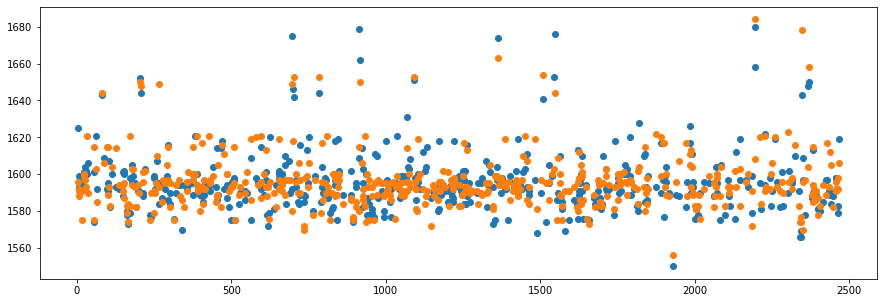

In [121]:
# plotting the prediction results
plt.figure(figsize=(15,5))
for i in [valid_target.values, dt_prediction]:
    plt.scatter(x = valid_target.index, y = i)

**Hyperparameters tuning**

In [122]:
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 60, num = 5)]
min_samples_split = [2, 5, 10, 15, 20, 25]
min_samples_leaf = [1, 2, 4, 5, 10, 15]

In [123]:
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [124]:
tr_and_valid_target = train_features.append(valid_features)
tr_and_valid_features = train_features.append(valid_features)

In [125]:
tuning_model = RandomizedSearchCV(estimator = dt_model, param_distributions = random_grid, random_state=42, scoring = 'neg_mean_absolute_error')

In [126]:
%%time
tuning_model.fit(tr_and_valid_features,tr_and_valid_target)

CPU times: total: 5.81 s
Wall time: 5.86 s


RandomizedSearchCV(estimator=DecisionTreeRegressor(random_state=146),
                   param_distributions={'max_depth': [5, 18, 32, 46, 60],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 5, 10,
                                                             15],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              25]},
                   random_state=42, scoring='neg_mean_absolute_error')

In [127]:
tuning_model.best_score_

-55.82580461389911

In [128]:
tuning_mae = abs(tuning_model.best_score_)

## 3.3 Gradient boosting model training.

In [129]:
param = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'verbose': -1,
    'metric' : 'mae',
    'learning_rate': 0.094,
    'max_depth': 150,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'subsample': 0.2
}

In [130]:
train_dataset = lgb.Dataset(train_features, train_target, feature_name=train_features.columns.tolist())
test_dataset = lgb.Dataset(valid_features, valid_target, feature_name=train_features.columns.tolist())

In [131]:
%%time
num_round = 144
bst = lgb.train(param, train_dataset, num_round,valid_sets= (test_dataset))

[1]	valid_0's l1: 10.3752
[2]	valid_0's l1: 10.0616
[3]	valid_0's l1: 9.83912
[4]	valid_0's l1: 9.62593
[5]	valid_0's l1: 9.4773
[6]	valid_0's l1: 9.28901
[7]	valid_0's l1: 9.05419
[8]	valid_0's l1: 8.87783
[9]	valid_0's l1: 8.69116
[10]	valid_0's l1: 8.53423
[11]	valid_0's l1: 8.38179
[12]	valid_0's l1: 8.24518
[13]	valid_0's l1: 8.1502
[14]	valid_0's l1: 8.02235
[15]	valid_0's l1: 7.93248
[16]	valid_0's l1: 7.85365
[17]	valid_0's l1: 7.83094
[18]	valid_0's l1: 7.76106
[19]	valid_0's l1: 7.67616
[20]	valid_0's l1: 7.59793
[21]	valid_0's l1: 7.53699
[22]	valid_0's l1: 7.50808
[23]	valid_0's l1: 7.48912
[24]	valid_0's l1: 7.42723
[25]	valid_0's l1: 7.38017
[26]	valid_0's l1: 7.32825
[27]	valid_0's l1: 7.31265
[28]	valid_0's l1: 7.30092
[29]	valid_0's l1: 7.25071
[30]	valid_0's l1: 7.23167
[31]	valid_0's l1: 7.2168
[32]	valid_0's l1: 7.19884
[33]	valid_0's l1: 7.18195
[34]	valid_0's l1: 7.1614
[35]	valid_0's l1: 7.1423
[36]	valid_0's l1: 7.11189
[37]	valid_0's l1: 7.0998
[38]	valid_0's l

In [132]:
bst_pred = bst.predict(valid_features)

In [133]:
bst_mae = mean_absolute_error(valid_target, bst_pred)

In [134]:
bst_mae

6.590727651085609

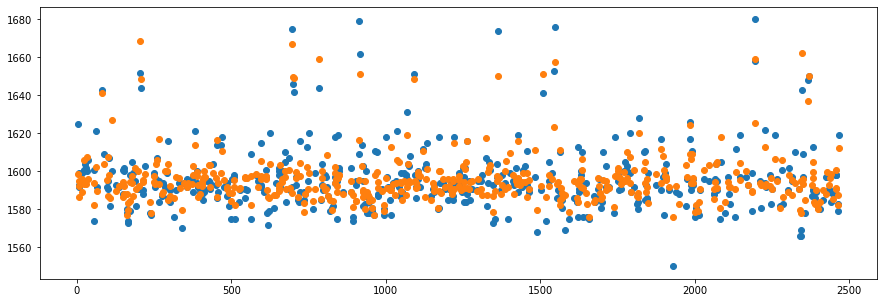

In [135]:
# Plotting of the results of prediction
plt.figure(figsize=(15,5))
for i in [valid_target.values, bst_pred]:
    plt.scatter(x = valid_target.index, y = i)

## 3.4 Training of neural network model

In [136]:
scaler = MinMaxScaler()

In [137]:
scaler.fit(features)

MinMaxScaler()

In [138]:
train_features_nn = scaler.transform(train_features)
valid_features_nn = scaler.transform(valid_features)
test_features_nn = scaler.transform(test_features)

In [139]:
train_features_nn = torch.tensor(train_features_nn)
train_target_nn = torch.tensor(train_target.values)
valid_features_nn = torch.tensor(valid_features_nn)
valid_target_nn = torch.tensor(valid_target.values)
test_features_nn = torch.tensor(test_features_nn)
test_target_nn = torch.tensor(test_target.values)

In [140]:
torch.manual_seed(1234)
input_size = 117
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 1

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1) 
        self.dp1 = nn.Dropout(p = 0.1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.dp2 = nn.Dropout(p = 0.05)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, output_size)  
        self.dp3 = nn.Dropout(p = 0.05)
        self.act3 = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.dp3(x)
        x = self.act3(x)
        return x
    
model_nn = NeuralNet(input_size, hidden_size_1, hidden_size_2, output_size)

In [141]:
%%time
optimizer = torch.optim.Adam(model_nn.parameters(),lr=0.01)

loss = torch.nn.L1Loss()

num_epochs = 1300

for epoch in range(num_epochs):
    optimizer.zero_grad()
    preds = model_nn.forward(train_features_nn.float()).flatten()
    loss_value = loss(preds,train_target_nn.float())
    loss_value.backward()
    optimizer.step()
    if (epoch % 8 == 0) or (epoch == 1300):
            model_nn.eval()
            valid_preds_nn = model_nn.forward(valid_features_nn.float()).flatten()
            loss_preds = loss(valid_preds_nn,valid_target_nn.float())
            print('valid_loss:',loss_preds)

valid_loss: tensor(1595.6625, grad_fn=<L1LossBackward0>)
valid_loss: tensor(1580.7507, grad_fn=<L1LossBackward0>)
valid_loss: tensor(1486.3174, grad_fn=<L1LossBackward0>)
valid_loss: tensor(1180.2782, grad_fn=<L1LossBackward0>)
valid_loss: tensor(477.6735, grad_fn=<L1LossBackward0>)
valid_loss: tensor(469.3812, grad_fn=<L1LossBackward0>)
valid_loss: tensor(267.5082, grad_fn=<L1LossBackward0>)
valid_loss: tensor(245.1849, grad_fn=<L1LossBackward0>)
valid_loss: tensor(223.9449, grad_fn=<L1LossBackward0>)
valid_loss: tensor(179.3494, grad_fn=<L1LossBackward0>)
valid_loss: tensor(155.8438, grad_fn=<L1LossBackward0>)
valid_loss: tensor(134.5383, grad_fn=<L1LossBackward0>)
valid_loss: tensor(117.7064, grad_fn=<L1LossBackward0>)
valid_loss: tensor(103.4455, grad_fn=<L1LossBackward0>)
valid_loss: tensor(90.4386, grad_fn=<L1LossBackward0>)
valid_loss: tensor(76.6585, grad_fn=<L1LossBackward0>)
valid_loss: tensor(63.7841, grad_fn=<L1LossBackward0>)
valid_loss: tensor(52.0735, grad_fn=<L1LossBack

valid_loss: tensor(8.2165, grad_fn=<L1LossBackward0>)
valid_loss: tensor(9.1799, grad_fn=<L1LossBackward0>)
valid_loss: tensor(8.7900, grad_fn=<L1LossBackward0>)
valid_loss: tensor(10.1234, grad_fn=<L1LossBackward0>)
valid_loss: tensor(9.7828, grad_fn=<L1LossBackward0>)
valid_loss: tensor(9.6122, grad_fn=<L1LossBackward0>)
valid_loss: tensor(9.7392, grad_fn=<L1LossBackward0>)
valid_loss: tensor(8.8040, grad_fn=<L1LossBackward0>)
CPU times: total: 28.5 s
Wall time: 7.38 s


In [142]:
mae_nn = mean_absolute_error(valid_preds_nn.detach().numpy(), valid_target)

In [143]:
mae_nn

8.804002549913195

In [144]:
valid_preds_nn_ = valid_preds_nn.detach().numpy()

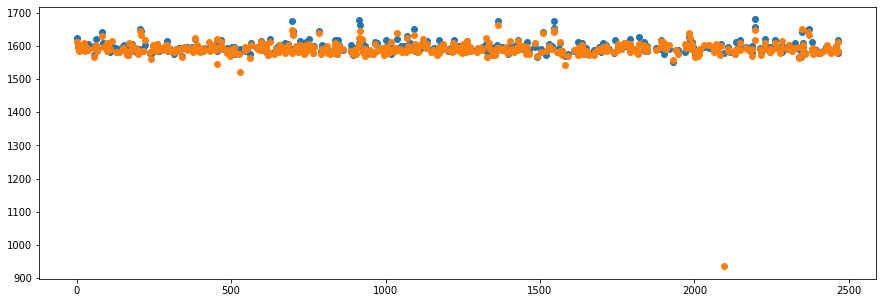

In [145]:
# Plotting the results of prediction
plt.figure(figsize=(15,5))
for i in [valid_target.values, valid_preds_nn_]:
    plt.scatter(x = valid_target.index, y = i)

## 3.5 Selection of the best model.

In [146]:
models = [dt_model,tuning_model,bst,model_nn]
mae_list = [dt_mae,tuning_mae,bst_mae,mae_nn]

In [147]:
models_df = pd.DataFrame({'model': models,'mae': mae_list})

In [148]:
models_df.sort_values(by='mae')

,model,mae
2,<lightgbm.basic.Booster object at 0x000001F84A...,6.590728
3,"NeuralNet(\n (fc1): Linear(in_features=117, o...",8.804003
0,DecisionTreeRegressor(random_state=146),9.765657
1,RandomizedSearchCV(estimator=DecisionTreeRegre...,55.825805


In [149]:
best_model_df = models_df[models_df['mae'] == models_df['mae'].min()]

In [150]:
best_model_df

,model,mae
2,<lightgbm.basic.Booster object at 0x000001F84A...,6.590728


In [151]:
best_model = best_model_df['model'].values[0]

In [152]:
best_model

<a name ='section_5'></a>
# 4 Model testing and demonstration of work:

- Prediction of test data on the selected best model;
- To conduct the analysis of features affecting the target;
- Plot the graph of dependance of features with highest affect on the target.

## 4.1 Model testing

In [153]:
test_preds = best_model.predict(test_features)

In [154]:
test_mae = mean_absolute_error(test_preds, test_target)

In [155]:
test_mae

5.957256233949206

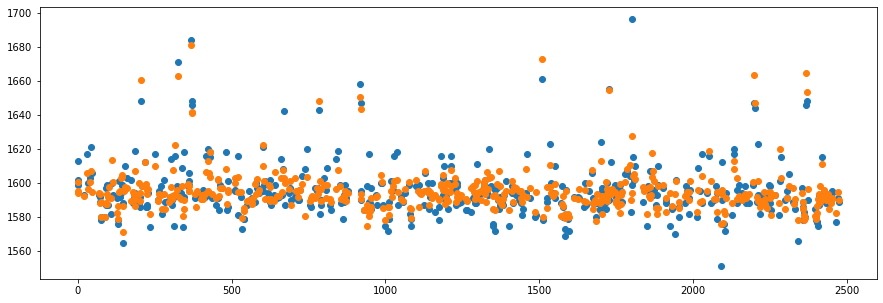

In [156]:
plt.figure(figsize=(15,5))
for i in [test_target.values, test_preds]:
    plt.scatter(x = test_target.index, y = i)

## 4.2 Analysis of affect of features on the target value

In [157]:
influence_factors_df = test_features.copy()

In [158]:
influence_factors_df['prediction'] = test_preds

In [159]:
# selection of columns for the check of affect on target
data_list = influence_factors_df.drop(columns = 'prediction').columns

# Loop for display of correlation value of feature to target
for data in data_list:
    print(data, 'coeff:', round(influence_factors_df['prediction'].corr(influence_factors_df[data])*100,2),'%')

first_temperature coeff: 47.53 %
Bulk 1 coeff: -4.21 %
Bulk 2 coeff: 0.2 %
Bulk 3 coeff: -9.7 %
Bulk 4 coeff: 5.94 %
Bulk 5 coeff: 0.11 %
Bulk 6 coeff: -22.06 %
Bulk 7 coeff: 1.81 %
Bulk 8 coeff: nan %
Bulk 9 coeff: -3.08 %
Bulk 10 coeff: -1.2 %
Bulk 11 coeff: -9.57 %
Bulk 12 coeff: 20.6 %
Bulk 13 coeff: 2.65 %
Bulk 14 coeff: 4.66 %
Bulk 15 coeff: -0.99 %
Wire 1 coeff: -10.08 %
Wire 2 coeff: -15.84 %
Wire 3 coeff: -1.16 %
Wire 4 coeff: -1.64 %
Wire 5 coeff: nan %
Wire 6 coeff: -5.14 %
Wire 7 coeff: -6.78 %
Wire 8 coeff: -3.07 %
Wire 9 coeff: -6.17 %
heating_qty coeff: 8.91 %
act_pwr_1 coeff: -9.64 %
act_pwr_2 coeff: 26.82 %
act_pwr_3 coeff: 26.3 %
act_pwr_4 coeff: 10.73 %
act_pwr_5 coeff: 6.21 %
act_pwr_6 coeff: 11.84 %
act_pwr_7 coeff: 8.38 %
act_pwr_8 coeff: 8.95 %
act_pwr_9 coeff: 6.25 %
act_pwr_10 coeff: 7.86 %
act_pwr_11 coeff: 9.89 %
act_pwr_12 coeff: 10.03 %
act_pwr_13 coeff: 10.2 %
act_pwr_14 coeff: 4.23 %
act_pwr_15 coeff: 4.23 %
act_pwr_16 coeff: nan %
react_pwr_1 coeff: -11.

**Analysis using phik matrix**

In [160]:
phik_mx = influence_factors_df.drop(columns = ['Bulk 8','Wire 5','act_pwr_16','react_pwr_16','Bulk 8_time_seconds',
                                     'heat_16_start_seconds','heat_16_finish_seconds','Wire 5_time_seconds']).phik_matrix()

interval columns not set, guessing: ['first_temperature', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'heating_qty', 'act_pwr_1', 'act_pwr_2', 'act_pwr_3', 'act_pwr_4', 'act_pwr_5', 'act_pwr_6', 'act_pwr_7', 'act_pwr_8', 'act_pwr_9', 'act_pwr_10', 'act_pwr_11', 'act_pwr_12', 'act_pwr_13', 'act_pwr_14', 'act_pwr_15', 'react_pwr_1', 'react_pwr_2', 'react_pwr_3', 'react_pwr_4', 'react_pwr_5', 'react_pwr_6', 'react_pwr_7', 'react_pwr_8', 'react_pwr_9', 'react_pwr_10', 'react_pwr_11', 'react_pwr_12', 'react_pwr_13', 'react_pwr_14', 'react_pwr_15', 'gas', 'first_temp_time_seconds', 'final_temp_time_seconds', 'Bulk 1_time_seconds', 'Bulk 2_time_seconds', 'Bulk 3_time_seconds', 'Bulk 4_time_seconds', 'Bulk 5_time_seconds', 'Bulk 6_time_seconds', 'Bulk 7_time_seconds', 'Bulk 9_time_seconds', 'Bulk 10_time_seconds', 

In [161]:
phik_mx

,first_temperature,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,...,heat_11_finish_seconds,heat_12_start_seconds,heat_12_finish_seconds,heat_13_start_seconds,heat_13_finish_seconds,heat_14_start_seconds,heat_14_finish_seconds,heat_15_start_seconds,heat_15_finish_seconds,prediction
first_temperature,1.000000,0.000000,0.227738,0.0,0.174106,0.289226,0.000000,0.181606,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.737505
Bulk 1,0.000000,1.000000,0.442517,0.0,0.149401,0.244812,0.000000,0.905982,0.000000,0.166056,...,0.632638,0.736144,0.736144,0.939967,0.939967,0.000000,0.000000,0.000000,0.000000,0.289630
Bulk 2,0.227738,0.442517,1.000000,0.0,0.278041,0.939734,0.000000,0.306977,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bulk 3,0.000000,0.000000,0.000000,1.0,0.000000,0.501175,0.337043,0.000000,0.215257,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bulk 4,0.174106,0.149401,0.278041,0.0,1.000000,0.000000,0.000000,0.136119,0.000000,0.193303,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
heat_14_start_seconds,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.722314,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.704284,0.704284,0.704284,0.120538
heat_14_finish_seconds,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.722314,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.704284,1.000000,0.704284,0.704284,0.120538
heat_15_start_seconds,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.722314,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.704284,0.704284,1.000000,0.704284,0.120538
heat_15_finish_seconds,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.722314,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.704284,0.704284,0.704284,1.000000,0.120538


In [162]:
# selection of features with highest affect
phik_mx[phik_mx['prediction'] != 0 ]['prediction'].sort_values(ascending = False).head(11)

prediction           1.000000
first_temperature    0.737505
react_pwr_3          0.674816
act_pwr_4            0.668048
Wire 1               0.578748
act_pwr_3            0.576382
react_pwr_4          0.515441
act_pwr_2            0.475136
heating_qty          0.472720
react_pwr_2          0.441378
react_pwr_13         0.423095
Name: prediction, dtype: float64

<AxesSubplot:title={'center':'% of influence phik correlation'}, xlabel='variable', ylabel='infleunce, %'>

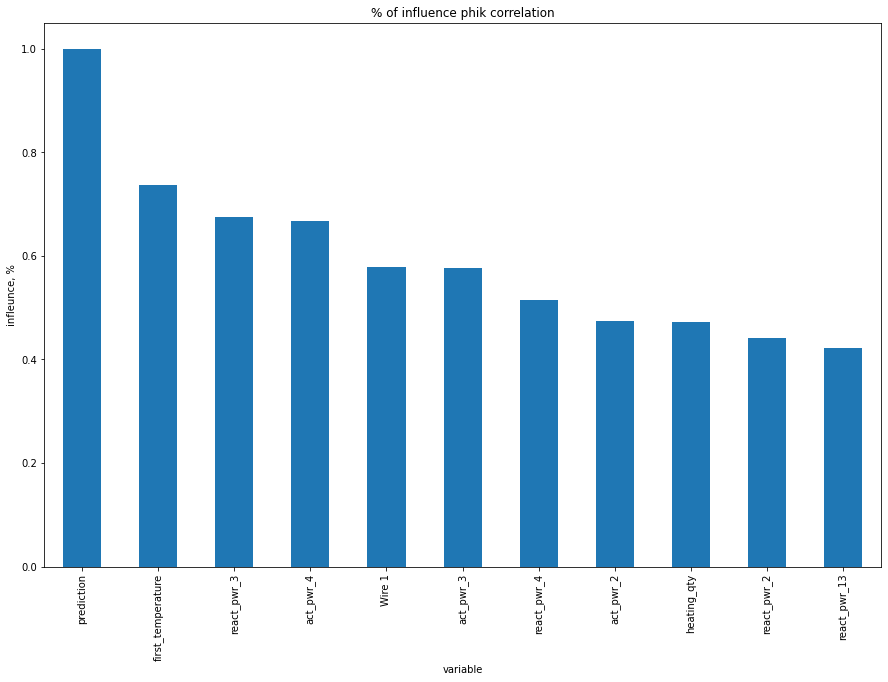

In [163]:
# plotting the histograms for features with highest affect
plt.figure(figsize=(15,10))
phik_mx[phik_mx['prediction'] != 0 ]['prediction'].sort_values(ascending = False).head(11).plot(kind = 'bar',
                                title = '% of influence phik correlation', xlabel = 'variable', ylabel = 'infleunce, %')

### Conclusion

**The highest affect on temperature has: - first temperature measurement and third reactive power**

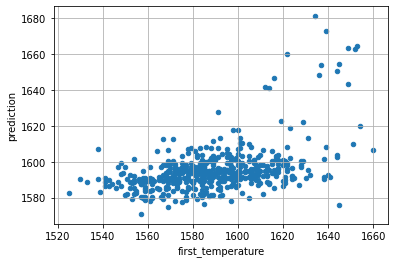

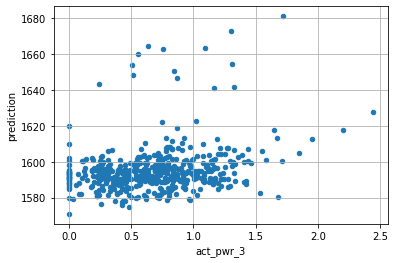

In [164]:
for i in ['prediction']:
    for j in ['first_temperature','act_pwr_3']:
        influence_factors_df.plot(y=i, x = j, kind = 'scatter', grid=True)

In [165]:
importances = dt_model.feature_importances_

In [166]:
model_importances = pd.Series(importances, index=features.columns)

In [167]:
model_importances = model_importances.sort_values(ascending=False).head(10)

In [168]:
std = np.std([dt_model.feature_importances_ for tree in str(1000)], axis=0)

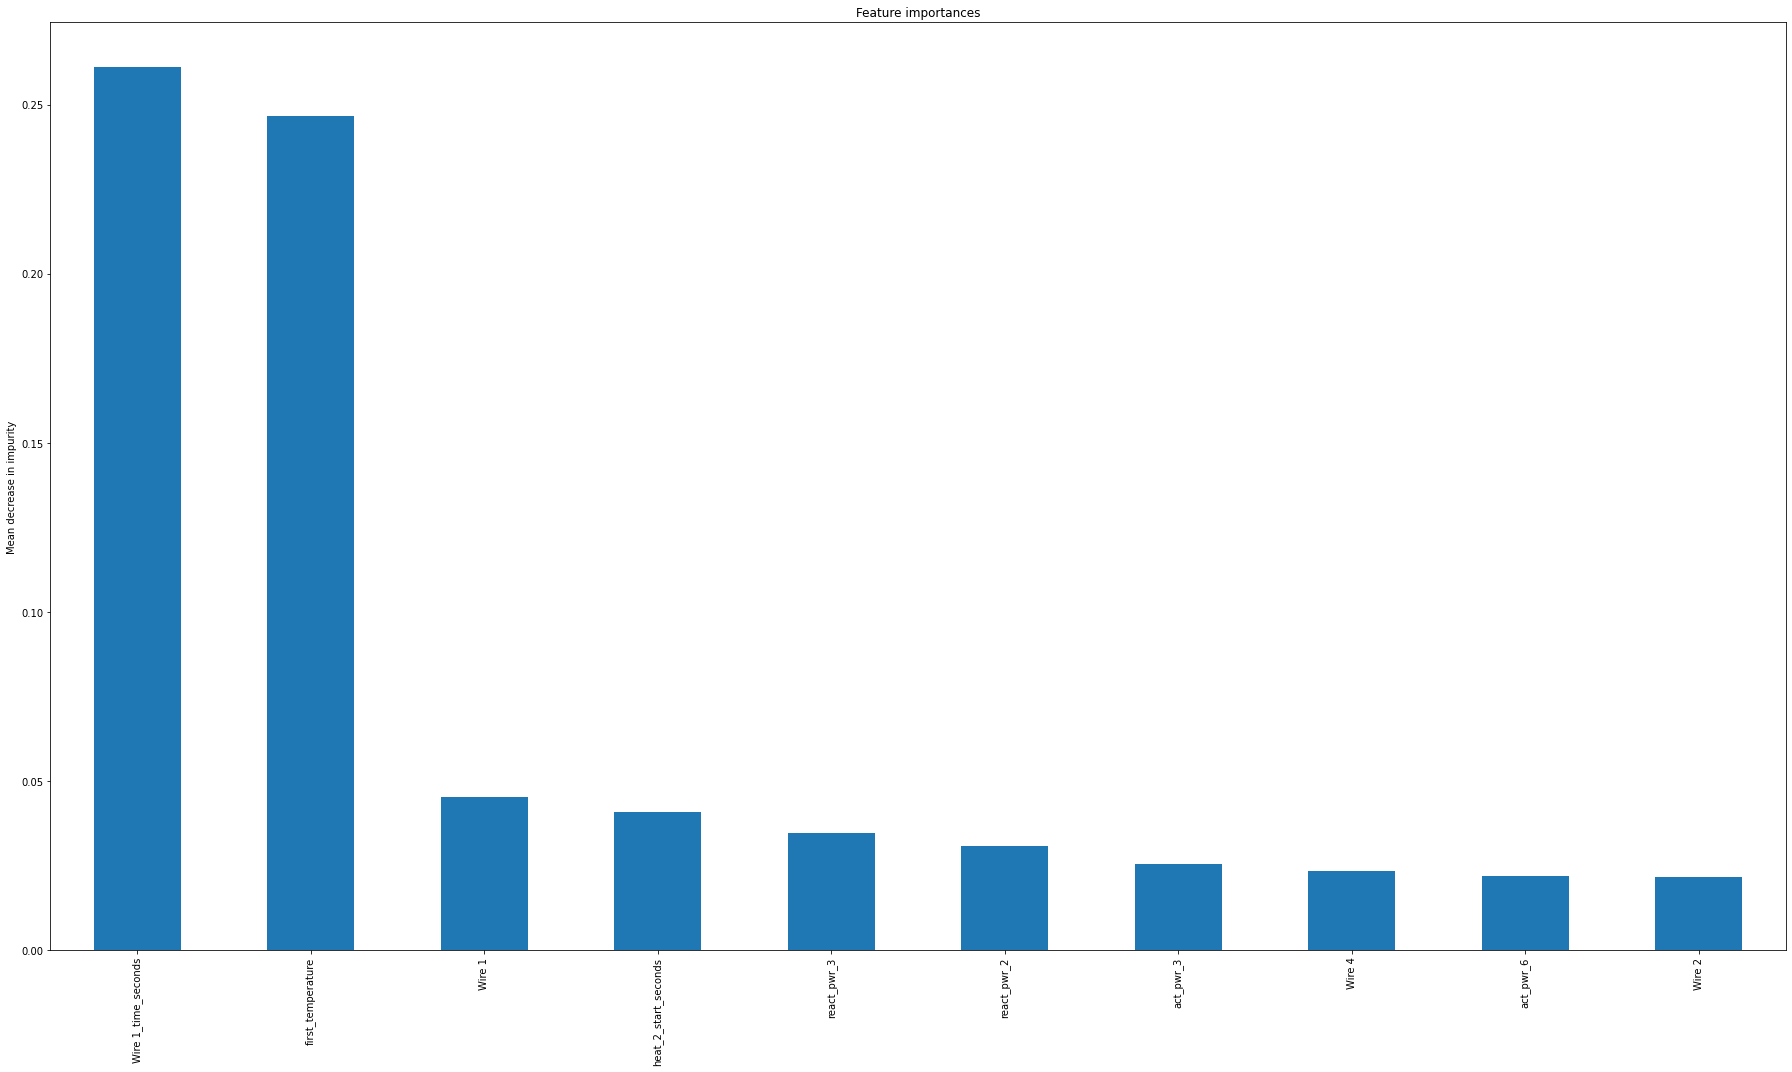

In [169]:
fig, ax = plt.subplots(figsize=(25,15))
model_importances.plot.bar(yerr=std[0:10], ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<a name = 'section_6'></a>
# 5 General Conclusions

**During the project realization the following tasks were completed:**
- Performed Exploratory data analysis;
- Data preparation, data cleaning, unification of formats;
- Three models were trined - with the best score МАЕ - 5,95, required score (МАЕ < 6) achieved;
- Best model was tested - МАЕ score is 5,95 on test sample;
- The features that affected the most are - reactive power and quantity of temperature measurement.